### For what purpose was the dataset created?
The dataset was created in a project that aims to contribute to the reduction of academic dropout and failure in higher education, by using machine learning techniques to identify students at risk at an early stage of their academic path, so that strategies to support them can be put into place. 

The dataset includes information known at the time of student enrollment – academic path, demographics, and social-economic factors. 

The problem is formulated as a three category classification task (dropout, enrolled, and graduate) at the end of the normal duration of the course. 

https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

# Steps in this notebook:

#### 1) Install packages
#### 2) Import the libraries
#### 3) Exploratory data analysis
#### 4) Pre-processing techniques
#### 5) Split data into training and testing sets
#### 6) Train the machine learning model

### 1) Install packages:

In [1]:
%pip install ucimlrepo
%pip install matplotlib
%pip install seaborn
%pip install -U scikit-learn
%pip install numpy
%pip install pandas
%pip install numexpr

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### 2) Import the libraries:

In [2]:
from ucimlrepo import fetch_ucirepo 
from pandas.core.computation.check import NUMEXPR_INSTALLED
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
from sagemaker.serializers import CSVSerializer

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
my_region = boto3.session.Session().region_name # set the region of the instance

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + xgboost_container + " container for your SageMaker endpoint.")

bucket_name = 'students-prediction-bucket' 
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Success - the MySageMakerInstance is in the sa-east-1 region. You will use the 855470959533.dkr.ecr.sa-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.
S3 error:  An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


In [4]:
 # fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
students_features = predict_students_dropout_and_academic_success.data.features 
students_targets = predict_students_dropout_and_academic_success.data.targets 
  
# features information 
print("Features Information:", students_features)

# targets information
print("Targets Information:", students_targets)

#variable information
print("Variables Information:", predict_students_dropout_and_academic_success.variables)


Features Information:       Marital Status  Application mode  Application order  Course  \
0                  1                17                  5     171   
1                  1                15                  1    9254   
2                  1                 1                  5    9070   
3                  1                17                  2    9773   
4                  2                39                  1    8014   
...              ...               ...                ...     ...   
4419               1                 1                  6    9773   
4420               1                 1                  2    9773   
4421               1                 1                  1    9500   
4422               1                 1                  1    9147   
4423               1                10                  1    9773   

      Daytime/evening attendance  Previous qualification  \
0                              1                       1   
1                            

### 3) Exploratory data analysis:

#### 3.1) Look for missing values in the features:

In [5]:
print(students_features.isnull().sum())

Marital Status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

There are no missing values in each feature of the database

#### 3.2) Look for outliers:

In [6]:
i = 1

fig = plt.figure(figsize = (130,130)) 

for fea in students_features:
    
    
        plt.subplot(9,4,i)
        ax = sns.boxplot(students_features[fea])
        sns.set(font_scale=3)
        
        i = i + 1
        
fig.suptitle('Boxplot of The Features', fontsize = 100, fontweight = 'extra bold')
        
plt.show()


#### 3.3) Remove outliers:

In [7]:
# calculate summary statistics
data_mean, data_std = students_features.mean(axis=0), students_features.std(axis=0)
# identify outliers:
# A value that falls outside of 2 standard deviations is part of the distribution
cut_off = data_std * 2
lower, upper = data_mean - cut_off, data_mean + cut_off

for x in students_features:
    students_features_new = students_features[(students_features[x] <= upper[x]) & (students_features[x] >= lower[x])]

print(students_features_new)


      Marital Status  Application mode  Application order  Course  \
0                  1                17                  5     171   
1                  1                15                  1    9254   
2                  1                 1                  5    9070   
3                  1                17                  2    9773   
4                  2                39                  1    8014   
...              ...               ...                ...     ...   
4419               1                 1                  6    9773   
4420               1                 1                  2    9773   
4421               1                 1                  1    9500   
4422               1                 1                  1    9147   
4423               1                10                  1    9773   

      Daytime/evening attendance  Previous qualification  \
0                              1                       1   
1                              1                   

There aren't outliers in this database, taking into consideration (as outliers) data that is not within two standard deviation from the mean

#### 3.4) Check correlation between features:

By means of the Pearson correlaion coefficients of the variables, it is possible to check the correlation
between the attributes. Highly correlated features are undesirable, since highly correlated variables only add redundant
information to the database, causing unnecessary memory occupation and slowing down the algorithm.

In [8]:
pearsoncorr = students_features_new.corr(method='pearson')

#defining figure size
fig = plt.figure(figsize = (110,110)) #figsize = (width,height)

#plotting the heatmap of the pearson correlation coefficient between the features 
ax = sns.heatmap(pearsoncorr)
    
sns.set(font_scale=80)
    
cbar = ax.collections[0].colorbar
cbar.set_label('Pearson Correlation Coefficient', labelpad=80)
                    
fig.suptitle('Pearson Correlation Coefficient Between The Features', fontsize = 100, fontweight = 'extra bold')

Text(0.5, 0.98, 'Pearson Correlation Coefficient Between The Features')

### 4) Pre-processing techniques:

#### 4.1) Data standardization:

Data standardization comes into the picture when features of the input data set have large differences between their ranges, or simply when they are measured in different units (e.g., pounds, meters, miles, etc.).

These differences in the ranges of initial features cause trouble for many machine learning models. For example, for the models that are based on distance computation, if one of the features has a broad range of values, the distance will be governed by this particular feature.

In [9]:
# define standard scaler 
scaler = StandardScaler() 
  
# transform data 
students_features_standardized = scaler.fit_transform(students_features_new)
print(students_features_standardized)

print("Variance ratio of each feature before data standardization:", (students_features.var(axis=0))) #variance!=1
print("Mean of each feature before data standardization:", students_features.mean(axis=0)) #mean!=0

print("Variance ratio of each feature after data standardization:", students_features_standardized.var(axis=0)) #variance=1
print("Mean of each feature after data standardization:", students_features_standardized.mean(axis=0)) #mean=0

[[-0.29482875 -0.09547022  2.49089589 ... -0.28763846  0.12438647
   0.76576084]
 [-0.29482875 -0.20986898 -0.55406775 ...  0.87622207 -1.10522155
   0.34719942]
 [-0.29482875 -1.01066035  2.49089589 ... -0.28763846  0.12438647
   0.76576084]
 ...
 [-0.29482875 -1.01066035 -0.55406775 ...  0.87622207 -1.10522155
   0.34719942]
 [-0.29482875 -1.01066035 -0.55406775 ... -0.81325289 -1.46687097
  -1.37551124]
 [-0.29482875 -0.4958659  -0.55406775 ...  0.42569541  1.7879738
  -0.74987207]]
Variance ratio of each feature before data standardization: Marital Status                                    3.669294e-01
Application mode                                  3.057141e+02
Application order                                 1.726052e+00
Course                                            4.258306e+06
Daytime/evening attendance                        9.727954e-02
Previous qualification                            1.043788e+02
Previous qualification (grade)                    1.739321e+02
Nacional

#### 4.2) Principal components analysis:

A set of features, initially correlated with each other, is linearly transformed into a considerably smaller set of uncorrelated variables, which hold most of the information of the original dataset, through the statistical technique of principal component analysis.

The advantage of applying this technique is that it is possible to represent most of the relevant material by choosing the principal components with the greatest variability. It is important to remember that all the components have information about each parameter. 

In [10]:
pca = PCA(n_components = 0.95) # principal components that explain 95% of the original database
pca_students_matrix = pca.fit_transform(students_features_standardized)
print("PCA Components Shape:", pca_students_matrix.shape)
print("Sum of Variance Ratio of All Components:", pca.explained_variance_ratio_.sum()*100) 
print("PCA Variance:",pca.explained_variance_)
# pca.explained_variance_/sum(pca.explained_variance_)
print("Variance Ratio:", pca.explained_variance_ratio_*100)
# the first principal component explains 17.66% of the dataset information/variance taking into account the total variance of the principal components

PCA Components Shape: (4424, 26)
Sum of Variance Ratio of All Components: 95.93305232532278
PCA Variance: [6.36134005 3.56012095 2.11099824 2.01117637 1.89379748 1.6831523
 1.59407908 1.53684336 1.2920377  1.23715981 1.0877276  1.01238267
 0.98774821 0.93439343 0.87225676 0.81274273 0.79060203 0.72858148
 0.63725514 0.58689239 0.56381405 0.53259128 0.46270443 0.45412614
 0.41443943 0.38474395]
Variance Ratio: [17.66639482  9.88698952  5.86255853  5.58533823  5.25935947  4.67436624
  4.42699655  4.26804437  3.58818235  3.43577823  3.02078258  2.81153843
  2.74312483  2.59495061  2.42238776  2.2571084   2.19562035  2.02337999
  1.76975304  1.62988815  1.56579612  1.4790858   1.28499956  1.26117636
  1.15096042  1.06849162]


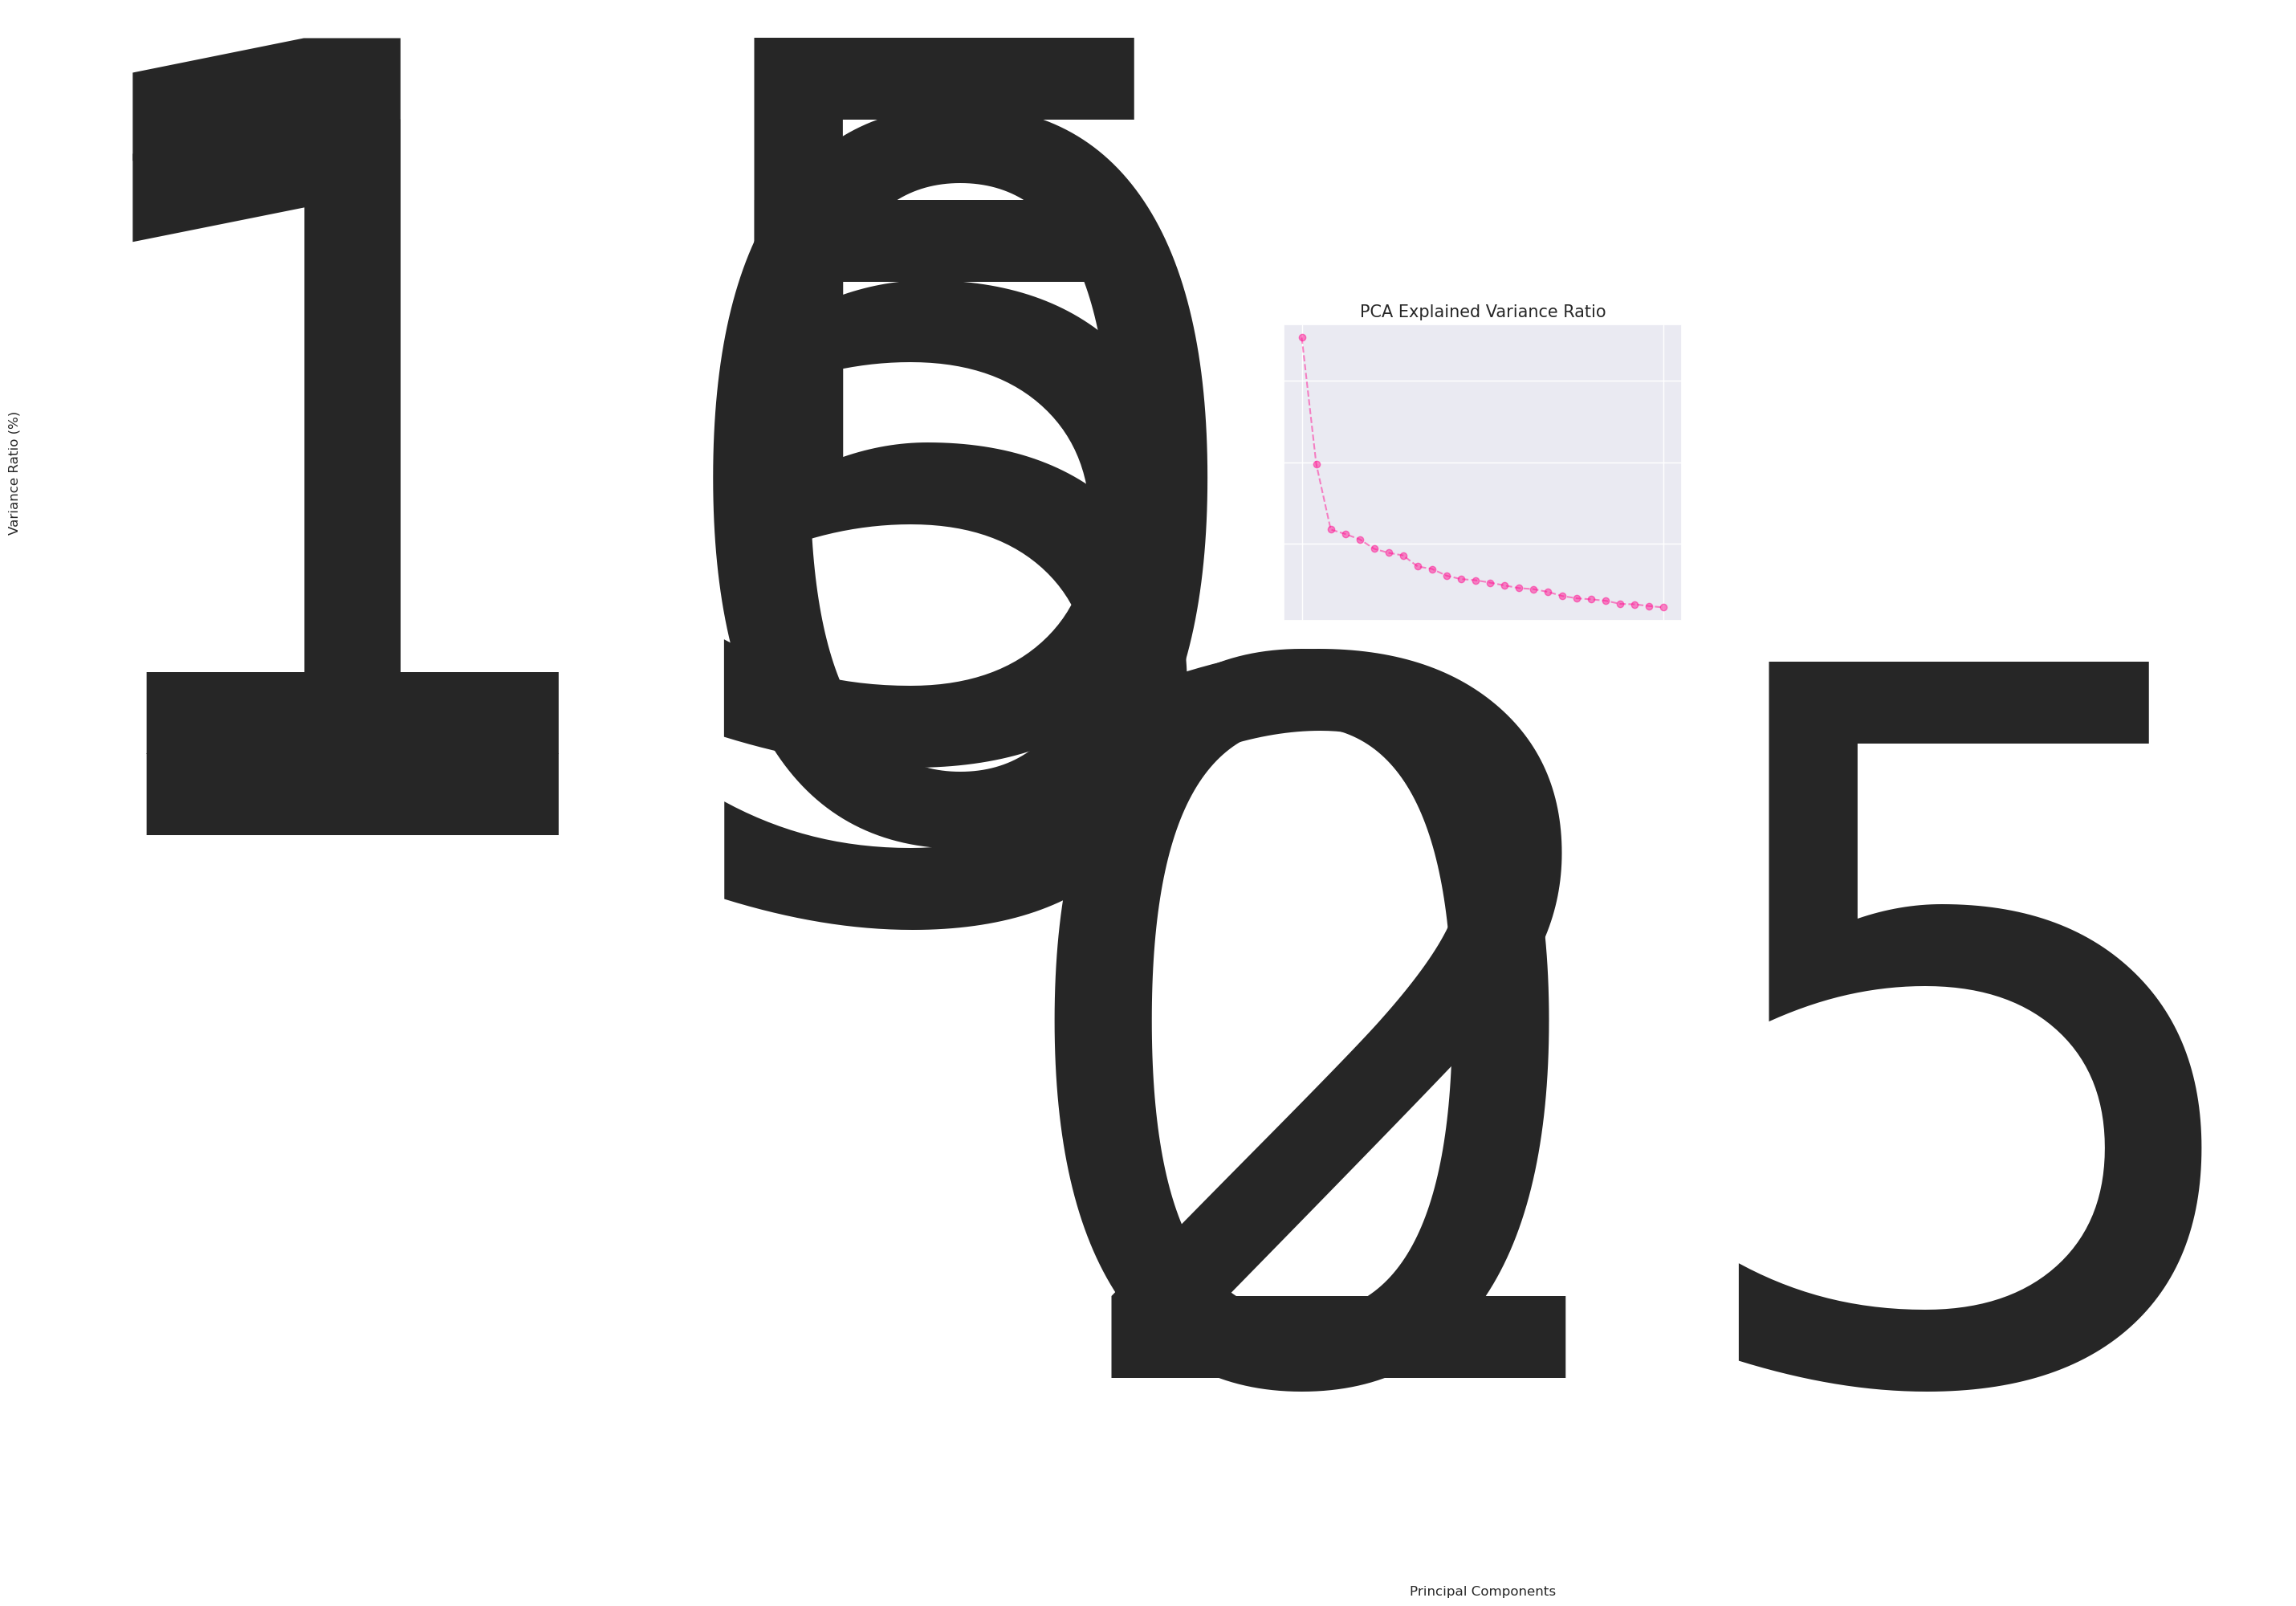

In [11]:
# plot principal components x variance graph
plt.plot(range(0,len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_ * 100, 'o--', alpha=0.5, color='deeppink')
plt.title("PCA Explained Variance Ratio", fontsize=15)
plt.xlabel('Principal Components', fontsize=12)
plt.ylabel('Variance Ratio (%)', fontsize=12)
plt.show()

In [12]:
[row, column] = pca_students_matrix.shape

columns_dataset = []

for col in range(column):
    
    columns_dataset.append('PC' + str(col))
    
pca_students_dataset = pd.DataFrame(pca_students_matrix, columns = columns_dataset)

pearsoncorr2 = pca_students_dataset.corr(method='pearson')

#defining figure size
fig = plt.figure(figsize = (50,50)) #figsize = (width,height)

#plotting the heatmap of the pearson correlation coefficient between the features 
ax = sns.heatmap(pearsoncorr2)
    
sns.set(font_scale=80)
    
cbar = ax.collections[0].colorbar
cbar.set_label('Pearson Correlation Coefficient', labelpad=80)
                    
fig.suptitle('Pearson Correlation Coefficient Between The Principal Components', fontsize = 100, fontweight = 'extra bold')

Text(0.5, 0.98, 'Pearson Correlation Coefficient Between The Principal Components')

### 5) Split the database into training set and testing set:

In [13]:
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(pca_students_dataset, students_targets, test_size = 0.3, random_state=1)
#x_training_data: variable linked to training data, y_training_data: variable linked to training classes
#x_test_data: variable linked to test data, y_test_data: variable linked to testing classes

### 6) Train the machine learning model:

#### 6.1)  Uploads data from S3 bucket. This step is required to use the Amazon SageMaker pre-built XGBoost algorithm:

In [14]:
x_training_data.to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

#### 6.2) Configure your Amazon SageMaker session, create an instance of the XGBoost model (an estimator), and define the model's hyperparameters:

In [15]:
# Configure your Amazon SageMaker session, 
# create an instance of the XGBoost model (an estimator), and define the model's hyperparameters.
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(xgboost_container,role, instance_count=1, instance_type='ml.m4.xlarge',output_path='s3://{}/{}/output'.format(bucket_name, prefix),sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=6, eta=0.2, gamma=4, min_child_weight=6, subsample=0.8, silent=0, num_round=100)
# XGBoost is an optimized distributed gradient boosting library designed to be highly efficient,
# flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. 
# XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


#### 6.3) This code trains the model using gradient optimization on an ml.m4.xlarge instance:

In [16]:
xgb.fit({'train': s3_input_train})

INFO:sagemaker:Creating training-job with name: xgboost-2023-11-29-22-25-51-177


2023-11-29 22:25:51 Starting - Starting the training job...
2023-11-29 22:26:18 Starting - Preparing the instances for training............
2023-11-29 22:27:57 Downloading - Downloading input data...
2023-11-29 22:28:32 Training - Downloading the training image...
2023-11-29 22:29:02 Training - Training image download completed. Training in progress..Arguments: train
[2023-11-29:22:29:19:INFO] Running standalone xgboost training.
[2023-11-29:22:29:19:INFO] Path /opt/ml/input/data/validation does not exist!
[2023-11-29:22:29:19:INFO] File size need to be processed in the node: 1.51mb. Available memory size in the node: 8542.79mb
[2023-11-29:22:29:19:INFO] Determined delimiter of CSV input is ','
[22:29:19] S3DistributionType set as FullyReplicated
[22:29:19] 3096x25 matrix with 77400 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[22:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=6
[0]#011trai


2023-11-29 22:29:39 Uploading - Uploading generated training model
2023-11-29 22:29:39 Completed - Training job completed
Training seconds: 103
Billable seconds: 103


### 7) Deploy the model:

In [17]:
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2023-11-29-22-30-04-341
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-11-29-22-30-04-341
INFO:sagemaker:Creating endpoint with name xgboost-2023-11-29-22-30-04-341


-----!